# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

In [3]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [4]:
grids = {}

# ERA5
#-----
# era_lat_range = slice(74,68)
# era_lon_range = slice(-165,-125)

era_lat_range = slice(90,65)
era_lon_range = slice(-180,180)
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
ds.close()
ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

grids['era'] = {}
grids['era']['lat'] = latgrid
grids['era']['lon'] = longrid


# PPD drift
#----------
drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
drift['lon'][drift['lon']>180]-=360
grids['ppd'] = {}
grids['ppd']['lat'] = drift['lat']
grids['ppd']['lon'] = drift['lon']
grids['ppd']['xx'] = drift['xx']
grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                
                if lon > -160:
                    grids[key]['region'][ii,jj] = True
                
                
                

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


for key in ['era', 'ppd']:
    ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
               zorder=100, s = 10, transform=ccrs.PlateCarree())

TypeError: 'datetime.datetime' object is not iterable

In [ ]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M1.nc')

In [ ]:
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


In [ ]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

## Identify continuous polynya sequences

In [5]:

all_seqs = {}
all_sizes = {}

event_dates = {}
event_dates['all'] = np.array([], dtype=np.datetime64)

event_dates['q4'] = np.array([], dtype=np.datetime64)
event_dates['q3'] = np.array([], dtype=np.datetime64)
event_dates['q2'] = np.array([], dtype=np.datetime64)
event_dates['q1'] = np.array([], dtype=np.datetime64)
event_dates['comp'] = np.array([], dtype=np.datetime64)


#===============================
years = np.append(np.arange(2003,2012), np.arange(2013,2026))
# years = np.arange(2003,2026)

size_thresh = 0        # polynya must reach this size at some point to be counted as event (km2)
start_size_thresh = 0  # size of openings to include as full window of event (km2)
#===============================

days_per_year = []
events_per_year = []

for year in years:
    
    print(year)
    
    # open data and crop to time range
#     DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.nc')

    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.2_radius25km.nc') as DS:
        time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
        DS = DS.sel(time = time_range)


        # linearly interpolate over any missing days
        extents = np.copy(DS.polynya_extent)

    #     is_date = np.where(pd.to_datetime(DS.time.values) == datetime(2016,4,30))[0]
    #     if len(is_date) >0:
    #         extents[is_date[0]] = DS.sel(time = datetime(2016,4,30)).other_polynya_extent.values


        extent_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                      pd.to_datetime(DS.time.values), 
                                                      extents, max_dt = 7 * units('day'))
    #     if len(is_date) >0:
    #         print('!!!!!')
    #         print(extent_interp[is_date[0]])


    #     extent_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
    #                                                   pd.to_datetime(DS.time.values), 
    #                                                   extents, max_dt = 7 * units('day'))


    #     DS['extent_interp'] = extent_interp


        event_dates['all'] = np.append(event_dates['all'], DS.time[extent_interp > 0])
        event_dates['q4'] = np.append(event_dates['q4'], DS.time[extent_interp > 1700])
        event_dates['q3'] = np.append(event_dates['q3'], DS.time[(extent_interp <= 1700)&(extent_interp > 500)])
        event_dates['q2'] = np.append(event_dates['q2'], DS.time[(extent_interp <= 500)&(extent_interp > 155)])
        event_dates['q1'] = np.append(event_dates['q1'], DS.time[(extent_interp <= 155)&(extent_interp > 0)])
        event_dates['comp'] = np.append(event_dates['comp'], DS.time[extent_interp == 0])



        # identify open periods
        open_cond = (extent_interp > start_size_thresh)
        open_dates = pd.to_datetime(DS.time.values[open_cond])
        days_per_year.append(len(open_dates))

        open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))
        events_per_year.append(len(open_seqs))

        large_seqs = {}

        cc = 0
        for jj in range(len(open_seqs)):
            # if polynya reach size threshold during event, add to large sequences

    #         current_vals = DS.extent_interp.sel(time = open_seqs[jj]).values

            date_indices = (DS.time.values >= open_seqs[jj][0]) & (DS.time.values <= open_seqs[jj][-1])
            current_vals = extent_interp[date_indices]

            if np.sum(current_vals > size_thresh) > 0:

                large_seqs[cc] = open_seqs[jj]
                cc+=1

        # add to master list
        ii = len(all_seqs)

        CC = 0
        for cc in range(len(large_seqs)):
            if len(large_seqs[cc]) > 0:

                date_indices = (DS.time.values >= large_seqs[cc][0]) & (DS.time.values <= large_seqs[cc][-1])
                all_seqs[ii+CC] = large_seqs[cc]
                all_sizes[ii+CC] = extent_interp[date_indices]#DS.extent_interp.sel(time = large_seqs[cc]).values
                CC+=1


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


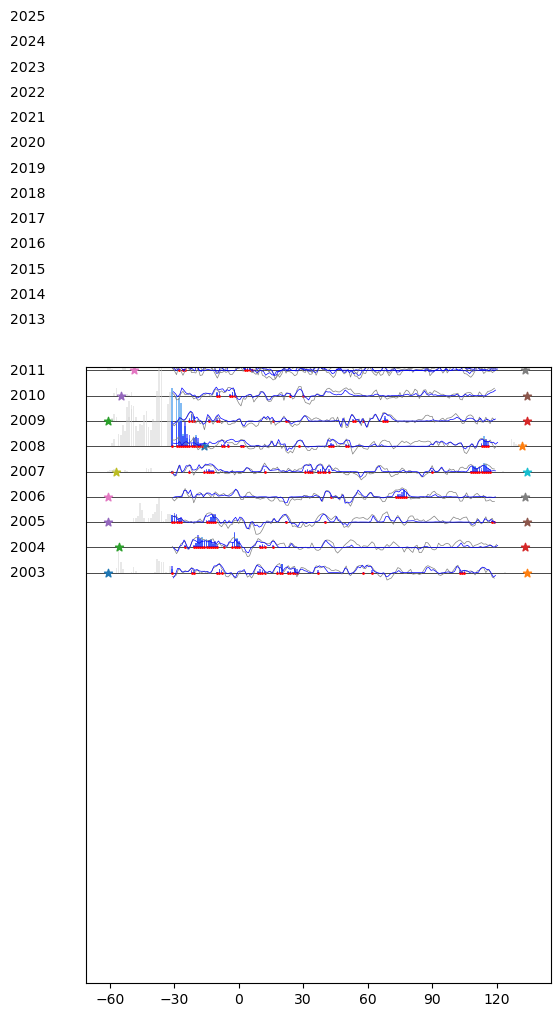

In [15]:

    
fig, ax = plt.subplots(figsize=(6,8))


ax.set_xticks([-60,-30,0,30,60,90,120,150])
ax.set_yticks([])

ax.set_ylim(-10, 185)

daily_counts = {}
long_wind_counts = {}
wind_counts = {}
polynya_counts = {}
months = [12, 1, 2, 3, 4]
for month in months:
    long_wind_counts[month] = {}
    wind_counts[month] = {}
    polynya_counts[month] = {}
    daily_counts[month] = {}
    for year in years:
        long_wind_counts[month][year] = 0
        wind_counts[month][year] = 0
        polynya_counts[month][year] = 0
        daily_counts[month][year] = 0
    
wind_durations = np.array([])    


groups = ['u10', 'v10', 't2m','msl', 'ui', 'vi', 'time']


annual_data = {}
annual_data['cum_polynya_extent'] = np.array([])
        
    
daily_data = {}
daily_data['ppd'] = {}
daily_data['era'] = {}
daily_data['pol'] = {}


daily_data['ppd']['ese'] = np.array([])
daily_data['ppd']['u'] = np.array([])
daily_data['ppd']['v'] = np.array([])
daily_data['ppd']['s'] = np.array([])
daily_data['ppd']['time'] = np.array([], dtype=np.datetime64)

daily_data['era']['ese'] = np.array([])
daily_data['era']['msl'] = np.array([])
daily_data['era']['u'] = np.array([])
daily_data['era']['v'] = np.array([])
daily_data['era']['s'] = np.array([])
daily_data['era']['t2m'] = np.array([])
daily_data['era']['time'] = np.array([], dtype=np.datetime64)

daily_data['pol']['extent'] = np.array([])

daily_data['pol']['length145'] = np.array([])
daily_data['pol']['length_max'] = np.array([])
daily_data['pol']['length_p95'] = np.array([])
daily_data['pol']['centermass_length'] = np.array([])
daily_data['pol']['centermass_direction'] = np.array([])
daily_data['pol']['max_length_direction'] = np.array([])
daily_data['pol']['width595'] = np.array([])
daily_data['pol']['width'] = np.array([])
daily_data['pol']['time'] = np.array([], dtype=np.datetime64)


# cond_data = {}
# cond_data['comp'] = {}
# cond_data['open'] = {}

# groups = ['u10', 'v10','t2m', 'ui', 'vi']
# for key in cond_data.keys():
#     for group in groups:
#         cond_data[key][group] = np.array([])


all_consol_dates = np.array([], dtype=np.datetime64)

missing_dates = np.array([], dtype = np.datetime64)

all_closures = np.array([])
all_breakups = np.array([])
        
for yy, year in enumerate(np.arange(1988,2026)):

# for yy, year in enumerate(np.arange(1987,2017)):

    # open polynya data and crop to time range
    #-----------------------------------------
    
    datei = datetime(year-1,12,1)
    datef = datetime(year,4,30)
    
    
    if (year >= 2003)&(year!=2012):
        
        YY = yy * 8
        ax.axhline(YY, c='k', lw=0.5, zorder=-1)
        ax.text(-90, YY, year, va='center', ha='right', clip_on=False)
        print(year)
        
        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.2_radius25km.nc') as DSo:


    #         DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.nc')

            time_range = slice(datetime(year-1,10,15), datetime(year,1,1,0) + timedelta(days=119+60))
        #     time_range = slice(datetime(year-1,10,1), datetime(year,4,30))
            DSo = DSo.sel(time = time_range)
#             DSo['length145'] = DSo['l_max']
#             DSo['length_max'] = DSo['max_length']
#             DSo['length_max_direction'] = DSo['max_length_direction']
#             DSo['centermass_direction'] = DSo['com_direction']
            
            DSo['width595'] = DSo['w_per95'] - DSo['w_per5']
            DSo['width'] = DSo['w_max'] - DSo['w_min']
            

            # find first and last closure dates
            dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days

            ice_area = (DSo.ice_extent.values)
            water_area = (DSo.polynya_extent + DSo.other_polynya_extent)
            total_area = (ice_area + water_area)

            if year == 2003:
                ice_across_years = ice_area
                water_across_years = water_area
            else:
                ice_across_years = np.append(ice_across_years, ice_area)
                water_across_years = np.append(water_across_years, water_area)


            # fifth day of compact conditions
            closure_ind = np.where(water_area == 0)[0][0]
            closure_date = dt_og[closure_ind]

            # last day of compact conditions
            breakup_ind = np.where(water_area == 0)[0][-1]
            breakup_date = dt_og[breakup_ind]

            ax.scatter(closure_date, YY, marker='*')
            ax.scatter(breakup_date, YY, marker='*')

            # re-define dt
        #     dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
            # plot polynya data
            ax.bar(dt_og, DSo.polynya_extent/1000, bottom=YY, color='lightgray', alpha=0.5)
        #     ax.bar(dt_og, DSo.other_polynya_extent/1000, bottom=YY, color='lightcoral', alpha=0.5)

            all_closures = np.append(all_closures,closure_date)
            all_breakups = np.append(all_breakups,breakup_date)


            # crop data between first, last closure dates
        #     closure_ind = np.where(dt_og==-31)[0][0]
        #     breakup_ind = np.where(dt_og==119)[0][0]

            closure_ind = np.where(pd.to_datetime(DSo.time.values) == datei)[0][0]
            breakup_ind = np.where(pd.to_datetime(DSo.time.values) == datef)[0][0]

        #     closure_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year-1,12,15))[0][0]
        #     breakup_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year,4,15))[0][0]


        #     closure_ind = np.where(dt_og==-61)[0][0]
        #     breakup_ind = np.where(dt_og==150)[0][0]

            DS = DSo.sel(time = slice(DSo.time[closure_ind],DSo.time[breakup_ind]))

            all_consol_dates = np.append(all_consol_dates, DS.time.values)

            # re-define dt
            dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days


            # save annual cumulative polynya area (over compact period)

            # flag missing dates
            missing_dates = np.append(missing_dates, DS.time[np.isnan(DS.polynya_extent.values)].values)

            extents = np.copy(DS.polynya_extent.values)

    #         is_date = np.where(pd.to_datetime(DS.time.values) == datetime(2016,4,30))[0]
    #         if len(is_date) >0:
    #             extents[is_date[0]] = DS.sel(time = datetime(2016,4,30)).other_polynya_extent.values


            extent_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          extents, max_dt = 7 * units('day'))
        
            length145_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.l_max.values, max_dt = 7 * units('day'))
            
            length_max_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.max_length.values, max_dt = 7 * units('day'))
            
            
            length_p95_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.l_per95.values, max_dt = 7 * units('day'))
            
            centermass_length_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.com_length.values, max_dt = 7 * units('day'))
            
            
            width_max_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.width.values, max_dt = 7 * units('day'))
            
            width_595_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
                                                          pd.to_datetime(DS.time.values), 
                                                          DS.width595.values, max_dt = 7 * units('day'))

    #         if len(is_date) >0:
    #             print('!!!!!')
    #             print(extent_interp[is_date[0]])

    #         total_extents = np.copy(DS.polynya_extent.values + DS.other_polynya_extent.values)
    #         tot_extent_interp, _ = tseries.linear_interpolate(pd.to_datetime(DS.time.values), 
    #                                                       pd.to_datetime(DS.time.values), 
    #                                                       total_extents, max_dt = 7 * units('day'))

            annual_data['cum_polynya_extent'] = np.append(annual_data['cum_polynya_extent'], np.nansum(extent_interp) )

            daily_data['pol']['extent'] = np.append(daily_data['pol']['extent'], extent_interp)
            daily_data['pol']['length145'] = np.append(daily_data['pol']['length145'], length145_interp)
            daily_data['pol']['length_max'] = np.append(daily_data['pol']['length_max'], length_max_interp)
            daily_data['pol']['length_p95'] = np.append(daily_data['pol']['length_p95'], length_p95_interp)
            daily_data['pol']['centermass_length'] = np.append(daily_data['pol']['centermass_length'], centermass_length_interp)
            
            daily_data['pol']['centermass_direction'] = np.append(daily_data['pol']['centermass_direction'], DS.com_direction)
            daily_data['pol']['max_length_direction'] = np.append(daily_data['pol']['max_length_direction'], DS.max_length_direction)
            
            
            daily_data['pol']['width595'] = np.append(daily_data['pol']['width595'], width_595_interp)
            daily_data['pol']['width'] = np.append(daily_data['pol']['width'], width_max_interp)
            daily_data['pol']['time'] = np.append(daily_data['pol']['time'], DS.time)
            


            # plot polynya data
            ax.bar(dt, DS.polynya_extent/1000, bottom=YY, color='dodgerblue', alpha=0.5)
            ax.scatter(dt[DS.polynya_extent.values>0], YY+np.zeros(np.sum(DS.polynya_extent.values>0)), s = 1, c='r')
            ax.bar(dt, DS.l_max/50, bottom=YY, color='b', alpha=0.5)


            open_cond = DS.polynya_extent > 0
            comp_cond = DS.polynya_extent == 0
            large_cond = DS.polynya_extent > 500
            inc_cond = np.diff(DS.polynya_extent) > 0
            dec_cond = np.diff(DS.polynya_extent) < 0

    else:
        for group in daily_data['pol'].keys():
            dates = pd.date_range(datei, datef)
            if group =='time':
                daily_data['pol']['time'] = np.append(daily_data['pol']['time'], dates)
            else:
                daily_data['pol'][group] = np.append(daily_data['pol'][group], np.full(len(dates), np.nan))
        
        
    # open daily wind data and crop to time range
    #----------------------------------------------
    if (year >= 1987) & (year <= 2025):
        
        
        if (year >= 2003)&(year < 2025):
            ds = xr.open_dataset(f'../data/forcing/regional_daily_era_{year}_v7_witht2m.nc')
        else:
            ds = xr.open_dataset(f'../data/forcing/regional_daily_era_{year}_v7.nc')
        crop_ds = ds.sel(time=slice(pd.to_datetime(datei), pd.to_datetime(datef)))
#         print(crop_ds.time[0], crop_ds.time[-1])
        dt2 = (pd.to_datetime(crop_ds.time.values) - datetime(year,1,1)).total_seconds()/(60*60*24)
        ESE = vectors.comp_along_theta(crop_ds.u10.values, crop_ds.v10.values, (175)*units('degree'))
        
        if (year >= 2003)&(year < 2024):
            daily_data['era']['t2m'] = np.append(daily_data['era']['t2m'], crop_ds.t2m)
        else:
            daily_data['era']['t2m'] = np.append(daily_data['era']['t2m'], np.full(len(crop_ds.msl), np.nan))
        daily_data['era']['msl'] = np.append(daily_data['era']['msl'], crop_ds.msl)
        daily_data['era']['s'] = np.append(daily_data['era']['s'], crop_ds.s10)
        daily_data['era']['u'] = np.append(daily_data['era']['u'], crop_ds.u10)
        daily_data['era']['v'] = np.append(daily_data['era']['v'], crop_ds.v10)
        daily_data['era']['ese'] = np.append(daily_data['era']['ese'], ESE)
        daily_data['era']['time'] = np.append(daily_data['era']['time'], crop_ds.time)
        if (year >= 2003)&(year < 2024):
            ax.plot(dt2, YY + 0.2*ESE, c='gray', lw=0.5)
        
    else:
        for group in daily_data['era'].keys():
            dates = pd.date_range(datei, datef)
            if group =='time':
                daily_data['era']['time'] = np.append(daily_data['era']['time'], dates)
            else:
                daily_data['era'][group] = np.append(daily_data['era'][group], np.full(len(dates), np.nan))
        
        
        
#         ax.plot(dt2, YY + 0.2*(crop_ds.t2m+20), c='r', lw=1, alpha=0.25)
    
    
    # open daily ice drift data and crop to time range
    #----------------------------------------------
    if (year >= 1987) & (year < 2024):
        dsp = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{year}_v7.nc')
        dsp = dsp.sel(time = slice(datei, datef))
        dt = (pd.to_datetime(dsp.time.values) - datetime(year,1,1)).days
#         ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (170)*units('degree'))
#         ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (162.5)*units('degree'))
#         ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (145)*units('degree'))
        ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (165)*units('degree'))

        
        daily_data['ppd']['ese'] = np.append(daily_data['ppd']['ese'], ese)
        daily_data['ppd']['u'] = np.append(daily_data['ppd']['u'], dsp.e)
        daily_data['ppd']['v'] = np.append(daily_data['ppd']['v'], dsp.n)
        daily_data['ppd']['s'] = np.append(daily_data['ppd']['s'], dsp.s)
        daily_data['ppd']['time'] = np.append(daily_data['ppd']['time'], dsp.time)
        
        if (year >= 2003)&(year < 2024):
            ax.plot(dt+0.5, YY+ 0.1*ese, c='b', lw=0.5)
        
    else:
        for group in daily_data['ppd'].keys():
            dates = pd.date_range(datei, datef)
            if group =='time':
                daily_data['ppd']['time'] = np.append(daily_data['ppd']['time'], dates)
            else:
                daily_data['ppd'][group] = np.append(daily_data['ppd'][group], np.full(len(dates), np.nan))
        
 

fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=330, bbox_inches='tight')

# ice_across_years = np.reshape(ice_across_years, (len(years), len(dt_og)))
# water_across_years = np.reshape(water_across_years, (len(years), len(dt_og)))
    
# find vector angles
daily_data['era']['angle'] = vectors.vector_angle(daily_data['era']['u'],daily_data['era']['v']).magnitude
daily_data['ppd']['angle'] = vectors.vector_angle(daily_data['ppd']['u'],daily_data['ppd']['v']).magnitude

# find vector speeds
daily_data['era']['s'] = np.sqrt(daily_data['era']['u']**2+daily_data['era']['v']**2)
daily_data['ppd']['s'] = np.sqrt(daily_data['ppd']['u']**2+daily_data['ppd']['v']**2)


all_consol_dates = pd.to_datetime(all_consol_dates)



for key in daily_data.keys():
    daily_data[key]['time'] = pd.to_datetime(daily_data[key]['time']) 
    daily_data[key]['month'] = np.array([date.month for date in daily_data[key]['time']])
    daily_data[key]['year'] = np.array([date.year if date.month!=12 else date.year+1 for date in daily_data[key]['time']])

In [16]:
all_polynya_sizes = daily_data['pol']['extent'][daily_data['pol']['extent']>0]

print(np.nanpercentile(all_polynya_sizes, 0))
print(np.nanpercentile(all_polynya_sizes, 5))
print(np.nanpercentile(all_polynya_sizes, 25))
print(np.nanpercentile(all_polynya_sizes, 50))
print(np.nanpercentile(all_polynya_sizes, 75))
print(np.nanpercentile(all_polynya_sizes, 95))
print(np.nanpercentile(all_polynya_sizes, 100))


38.9534950891628
38.969272880972426
155.9639379724051
545.6294396646608
1676.8633785243364
5902.1477444047705
26031.20071148633


In [18]:
cmp = {}

# time info
cmp['time'] = pd.to_datetime(daily_data['pol']['time'])
cmp['month'] = daily_data['pol']['month']
cmp['year'] = daily_data['pol']['year']

# time periods
cmp['pre_2003'] = (daily_data['ppd']['year']<2003)
cmp['2003_2023'] = (daily_data['ppd']['year']>=2003) & (daily_data['ppd']['year']<2024)

# polynya-related bools
cmp['compact'] = (daily_data['pol']['extent']==0)
cmp['open'] = (daily_data['pol']['extent']>0)
cmp['q1'] = (daily_data['pol']['extent'] > 0) & (daily_data['pol']['extent'] <= 155)
cmp['q2'] = (daily_data['pol']['extent'] > 155) & (daily_data['pol']['extent'] <= 545)
cmp['q3'] = (daily_data['pol']['extent'] > 545) & (daily_data['pol']['extent'] <= 1715)
cmp['q4'] = (daily_data['pol']['extent'] > 1715) 

# polynya stats
cmp['extent'] = daily_data['pol']['extent']
cmp['length_145'] = daily_data['pol']['length145']
cmp['length_max'] = daily_data['pol']['length_max']

cmp['centermass_length'] = daily_data['pol']['centermass_length']
cmp['length_p95'] = daily_data['pol']['length_p95']

cmp['centermass_direction'] = daily_data['pol']['centermass_direction']
cmp['max_length_direction'] = daily_data['pol']['max_length_direction']

cmp['width595'] = daily_data['pol']['width595']
cmp['width'] = daily_data['pol']['width']

            

# comp_ = (daily_data['pol']['extent']==0) & base_cond
# open_ = (daily_data['pol']['extent']>0) & base_cond
# open_strict = (open_)&(last_days_of_seqs == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)

# ice velocities
cmp['ai'] = daily_data['ppd']['angle']
cmp['si'] = daily_data['ppd']['s']
cmp['ui'] = daily_data['ppd']['u']
cmp['vi'] = daily_data['ppd']['v']

# wind data
cmp['a10'] = daily_data['era']['angle']
cmp['s10'] = daily_data['era']['s']
cmp['u10'] = daily_data['era']['u']
cmp['v10'] = daily_data['era']['v']
cmp['t2m'] = daily_data['era']['t2m']
cmp['msl'] = daily_data['era']['msl']

df = pd.DataFrame(cmp)

# print(df)
# df.to_csv('../data/compiled_stats.csv', index=False)

## Add timing of events

In [19]:
year_start = np.full(len(df.time), False)
year_end = np.full(len(df.time), False)

# maker beginning and end of each year
for dd, date in enumerate(df.time):
    
    if (date.month == 4)&(date.day == 30):
        year_end[dd] = True
    
    elif (date.month == 12)&(date.day == 1):
        year_start[dd] = True
        
df['year_start'] = year_start
df['year_end'] = year_end


# flag missing sic dates
missing = np.full(len(df.time), False)
for dd, date in enumerate(df.time):
    if date in missing_dates:
        missing[dd] = True
df['missing_sic'] = missing

In [20]:
# start array to list event days
event_days = np.full(len(df.time), -999)

day_before_events = np.full(len(df.time), -999)
day_after_events = np.full(len(df.time), -999)

day_before_withflag = np.full(len(df.time), -999)
day_after_withflag = np.full(len(df.time), -999)


sequence_nums = np.full(len(df.time), -999)

overlap_flag = np.full(len(df.time), False)
singleday_event_flag = np.full(len(df.time), False)

season_start_flag = np.full(len(df.time), False)
season_end_flag = np.full(len(df.time), False)

first_day = np.full(len(df.time), False)
final_day = np.full(len(df.time), False)
peak_day = np.full(len(df.time), False)


num_day_bef = 7
num_day_aft = 7

for ss in all_seqs:
    
    # save sequence number
    for dd, date in enumerate(all_seqs[ss]):
        sequence_nums[np.where(df.time == date)[0][0]] = ss+1
    
    # identify first and last days of sequences
    first_day[np.where(df.time == all_seqs[ss][0])[0][0]] = True
    final_day[np.where(df.time == all_seqs[ss][-1])[0][0]] = True
    # peak size of event
    peak_day[np.where(df.time == all_seqs[ss][np.argmax(all_sizes[ss])])[0][0]] = True
    
    # flag events occuring at beginning of season
    if datetime(all_seqs[ss][0].year, 12, 1) in all_seqs[ss]:
        for dd, date in enumerate(all_seqs[ss]):
            season_start_flag[np.where(df.time == date)[0][0]] = True
      
    # flag events occuring at end of season
    if datetime(all_seqs[ss][-1].year, 4, 30) in all_seqs[ss]:
        for dd, date in enumerate(all_seqs[ss]):
            season_end_flag[np.where(df.time == date)[0][0]] = True
    
    # flag single-day events
    if len(all_seqs[ss]) == 1:
        singleday_event_flag[np.where(df.time == all_seqs[ss][0])[0]] = True
    
    # during event
    #--------------------------------------------
    # loop through and save each day of event
    for dd, date in enumerate(all_seqs[ss]):
        event_days[np.where(df.time == date)[0][0]] = dd+1
        
    # identify start date of each event
    date_start = all_seqs[ss][0] 
    date_end = all_seqs[ss][-1] 
    
    
    # before event
    #--------------------------------------------
    FLAG = False
    
    # loop through days before event
    for nn in range(1, num_day_bef+1):
        date = date_start - timedelta(days = nn)
        
        # save date to array
#         day_before_events[np.where(df.time == date)[0]] = -nn
        
        # flag if it overlaps with another event
        if date in df.time[df.extent>0].values:
            FLAG = True
            overlap_flag[np.where(df.time == date)[0]] = True
            
        if not FLAG:
            
            day_before_withflag[np.where(df.time == date)[0]] = -nn
            
            
    # after event
    #--------------------------------------------
    FLAG = False
    
    # loop through days before event
    for nn in range(1, num_day_aft+1):
        
        date = date_end + timedelta(days = nn)
        
        # save date to array
#         day_after_events[np.where(df.time == date)[0]] = nn
        
        # flag if it overlaps with another event
        if date in df.time[df.extent>0].values:
            FLAG = True
            overlap_flag[np.where(df.time == date)[0]] = True

        if not FLAG:
            day_after_withflag[np.where(df.time == date)[0]] = nn

        
df['sequence'] = sequence_nums

df['event_day'] = event_days
df['day_before_event'] = day_before_withflag
df['day_after_event'] = day_after_withflag
df['overlap_flag'] = overlap_flag
df['single_day'] = singleday_event_flag

df['season_start_flag'] = season_start_flag
df['season_end_flag'] = season_end_flag

df['first_day'] = first_day
df['final_day'] = final_day
df['peak_day'] = peak_day



# let's omit these - they overwrite events
# df['days_before_event'] = day_before_events
# df['days_after_event'] = day_after_events



# record total event length along axis
event_length = np.full(len(df['event_day']), -999)

# loop over every event length
for L in range(1, df['event_day'].max()+1):

    # find which sequences include this event length
    # and only save those which are exactly this length
    exact_length_ss = []
    for ss in df['sequence'][df['event_day'] == L].values:
        if df['event_day'][df['sequence']==ss].max() == L:
            exact_length_ss.append(ss)
          
    # record total event length
    for ss in exact_length_ss:
        event_length[df['sequence'] == ss] = L

df['event_length'] = event_length

In [21]:
df['extent'][df['time'] == datetime(2016,4,30)]

4386    26031.200711
Name: extent, dtype: float64

In [22]:
df['sequence'][df['time'] == datetime(2016,4,30)]

4386    86
Name: sequence, dtype: int64

In [23]:
before_event_length = np.full(len(df['event_length']), -999)
after_event_length = np.full(len(df['event_length']), -999)


for ss in list(set(df.sequence)):
    
    # record event length
    L = df['event_length'][df['sequence'] == ss].values[0]
    
    # find event start and end
    date_start = pd.to_datetime(df.time[df['sequence'] == ss].values[0])
    date_end = pd.to_datetime(df.time[df['sequence'] == ss].values[-1])

    # loop through days before event
    #-------------------------------
    for nn in range(1, num_day_bef+1):
        
        date = date_start - timedelta(days = nn)
        ii = np.where(df.time==date)[0]
        
        # if date exists
        if (len(ii)>0):

            # save event length if still considered part of before event period
            if (df.day_before_event[ii].values[0] != -999):
                before_event_length[ii] = L
            else:
                break # encountered other event
        else:
            break # date not found

    # loop through days after event
    #-------------------------------
    for nn in range(1, num_day_aft+1):
        
        date = date_end + timedelta(days = nn)
        ii = np.where(df.time==date)[0]
        
        # if date exists
        if (len(ii)>0):
            # save event length if still considered part of before event period
            if (df.day_after_event[ii].values[0] != -999):
                after_event_length[ii] = L
            else:
                break # encountered other event
        else:
            break # date not found


df['after_event_length'] = after_event_length
df['before_event_length'] = before_event_length

### Save to file

In [24]:
# df.to_csv('../data/compiled_stats.csv', index=False)

In [25]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2025.nc')

ds

<xarray.Dataset>
Dimensions:     (valid_time: 744, latitude: 41, longitude: 401)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-03-01 ... 2025-03-31T23:00:00
  * latitude    (latitude) float64 75.0 74.75 74.5 74.25 ... 65.5 65.25 65.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... -80.5 -80.25 -80.0
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-28T23:09 GRIB to CDM+CF via cfgrib-0.9.1...